# Time series

This notebook is dedicated to analyze how have the Amazon fine food reviews changed in time.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
data = pd.read_csv('data/Reviews.csv', index_col='Id')
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data = data.sort_values('Time').reset_index(drop=True)

In [3]:
data.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...
1,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
3,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
4,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


In [4]:
len(data.ProductId.unique()) # 74258
len(data.UserId.unique()) # 256059

256059

Since we have over 70 000 products and over 250 000 users, it is difficult to analyze them individually. I will focus on observing trends, and finding artefacts in data.

# Score

In [5]:
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

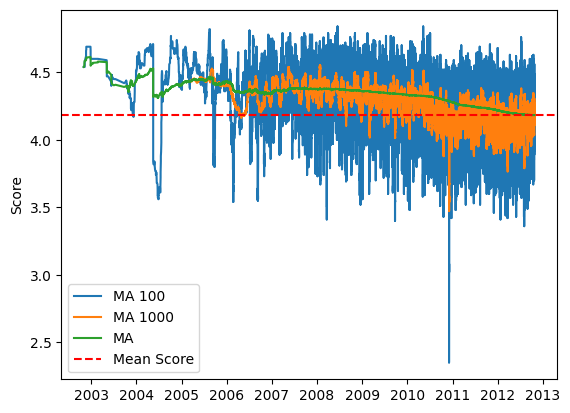

In [70]:
moving_average_full = np.cumsum(data.Score).div(data.index.to_series() + 1)[99:]
moving_average_100 = moving_average(data.Score.to_numpy(), 100)
moving_average_1000 = moving_average(data.Score.to_numpy(), 1000)

plt.plot(data.Time[99:], moving_average_100, label='MA 100')
plt.plot(data.Time[999:], moving_average_1000, label='MA 1000')
plt.plot(data.Time[99:], moving_average_full, label='MA')
plt.axhline(y=data.Score.mean(), color='r', linestyle='--', label='Mean Score')
plt.legend()
plt.ylabel('Score')
plt.show()

We can observe, that the avarage score of the products is decreasing in time, which might mean, that users are less and less satisfied with the products they buy, or their demands increase. Additionally, we can observe unusual artefact just before the begining of 2011, where the moving average of last hundred scores drop below 2.5 (being within 3.5 - 5.0 almost all the time).

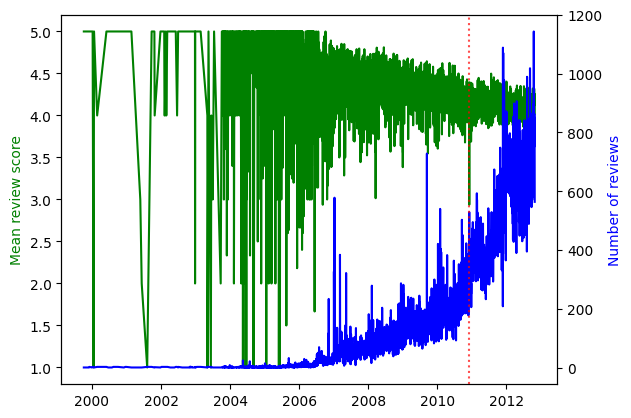

In [52]:
outlier = np.argmin(moving_average_100)

score_count = data.groupby('Time')['Score'].count()
score_mean = data.groupby('Time')['Score'].mean()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(score_count.index.to_series(), score_mean, 'g-')
ax2.plot(score_count.index.to_series(), score_count, 'b-')

# ax1.set_xlabel('Date')
plt.axvline(x=data.Time[outlier], color='r', linestyle='dotted', label='Outlier', alpha=0.7)
ax1.set_ylabel('Mean review score', color='g')
ax2.set_ylabel('Number of reviews', color='b')

plt.show()

It appears, that that the special artefact observed in the previous plot is due to relatively low score observed in 2010-12-04.

In [73]:
# data[data.Time == '2010-12-04'] # 529
# data[(data.Time == '2010-12-04') & (data.UserId == 'A3TVZM3ZIXG8YW')] # 199
# data[(data.Time == '2010-12-04') & (data.Text == 'This review will make me sound really stupid, but whatever. I don\'t really care as long as people find out what\'s real and can avoid my mistakes.<br /><br />I got my wonderful little sweet Bella Bean when she was a few days shy of three years old. She had been bounced around from house to house and eating whatever was cheap. I have had cats around me my entire life, for about twenty-five years now. My mother always just fed them whatever, the kinds of food you buy in the supermarket - Friskies, Nine Lives, Kit & Kaboodle, stuff like that. And our cats were always fine, at least in terms of their eating habits. They would eat in the morning, stop when they were done, come back, and eat some more when they got hungry.<br /><br />My housemate at the time was working for Hill\'s and assured me that this was the best food ever made, so great, so on and so forth. I now know that she is an utter buffoon, but I initially trusted her judgment, which is so unfortunate because she doesn\'t think. She also had plenty of coupons for free or deeply discounted bags, which made it a much more attractive choice.<br /><br />I first tried feeding the little Bean an unmeasured amount of Science Diet in a bowl, but that didn\'t work, as she would devour it in one sitting. So then I took to measuring it, and she did the same thing. Then I started parsing it out to twice a day. That didn\'t work either, because she would start going crazy in the middle of the day, running around, intentionally destroying things, deliberately spilling her water, crying, etc., until she got more food. So then I split it into three servings. Same thing. Then it got to be four servings. That was a little better, but it was too much maintenance and unrealistic to be around every day to feed her four times. So then it went back to three. All the while, I was trying to reduce the amount of food I was feeding her to less than 3/4 of a cup because she was a little chubby. Reducing was hell. She became even more hungry, but I figured she would get used to it. Not really.<br /><br />For over a year, she would wake me up every morning looking for food in a serious way, knocking things off my desk, ripping up any paper she could find, scratching at the door and committing general acts of mischief. As soon as she got food, she was back to her sweet self, but only for three or four hours.<br /><br />We thought she was bored, we thought she was a little nutty, and maybe even had a kitty eating disorder. She always wanted food. It was kind of funny but in the end it was just sad.<br /><br />A few weeks back, we took her to a new (good, non-money factory) vet for her second checkup since I\'ve had her. I talked with him about her being always hungry. He asked what she ate, and I told him the adult indoor Science Diet. Without saying as much, he basically told me that this food is garbage and I should look for something else. He said cat food should have a protein followed by a carbohydrate as the first two ingredients. Science Diet does, in a very loose, by-product kind of way - ground up slaughterhouse leftovers and corn dust. Then they put a bunch of vitamins in it to make it "healthy," instead of just using good ingredients from the beginning. Not that I care about spending money on the Bean, but this food is way too expensive for what it is.<br /><br />So we began transitioning her onto Wellness indoor formula about two weeks ago. She is still eating 50 percent Science Diet with 50 percent Wellness (you really shouldn\'t just give a cat different food one day out of the blue) but SHE NEVER FREAKS OUT ANYMORE. It\'s amazing. And it\'s 100 percent because she is eating real food now, along with that sawdust and chicken hearts I still regrettable have to feed her. We have her down to eating twice a day, only 1/3 cup in TOTAL. She was eating three times a day, 5/8 of a cup in total. Now she eats some in the morning, walks away, eats some more a few hours later, and then looks for dinner about twelve hours after her initial feeding. No more knocking things over, no more trashing Dad\'s papers on the desk, no more howling, no more deliberately spilled water on the floor. It\'s incredible.<br /><br />I feel so bad that I was doing this to her for so long. We really thought she was just being dramatic or whatever. But no, she was genuinely hungry because she wasn\'t eating any real food.<br /><br />Do your cat a favor - buy her or him so food made with real ingredients, things you would eat - Wellness, Halo, Innova, Evo, whatever. Figure it out for yourself, but please don\'t feed your cat this. It\'s garbage.')] # 199

Eventually, it turned out that the low score in 2010-12-04 is due to one user, that wrote a very long comment, which probably had to be seperated into smaller comments by the service, and resulted in 199 comments with score 1 in our dataset. Nothing revolutionary, but what a story...

In [74]:
print(data.iloc[197268].Text)

This review will make me sound really stupid, but whatever. I don't really care as long as people find out what's real and can avoid my mistakes.<br /><br />I got my wonderful little sweet Bella Bean when she was a few days shy of three years old. She had been bounced around from house to house and eating whatever was cheap. I have had cats around me my entire life, for about twenty-five years now. My mother always just fed them whatever, the kinds of food you buy in the supermarket - Friskies, Nine Lives, Kit & Kaboodle, stuff like that. And our cats were always fine, at least in terms of their eating habits. They would eat in the morning, stop when they were done, come back, and eat some more when they got hungry.<br /><br />My housemate at the time was working for Hill's and assured me that this was the best food ever made, so great, so on and so forth. I now know that she is an utter buffoon, but I initially trusted her judgment, which is so unfortunate because she doesn't think. S

# Growth of database

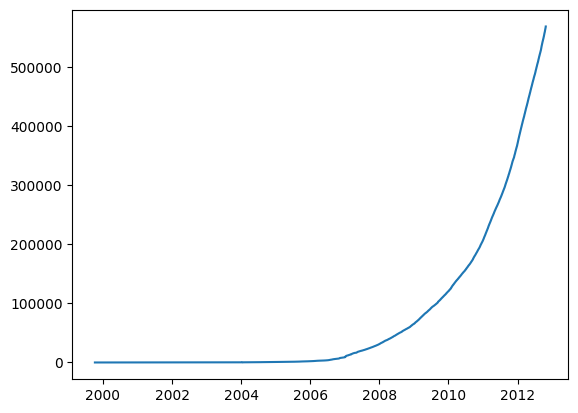

In [7]:
plt.plot(data.Time, data.index.to_series() + 1, label='All reviews')
plt.plot()
plt.show()